# Lab 3: Clustering with Wine Dataset (K-Means vs K-Medoids)

**Name:** Maduri Ramadoss  
**Course:** Advanced Big Data and Data Mining (MSCS-634-M20)  
**Lab Assignment:** Lab 3: Clustering Analysis Using K-Means and K-Medoids Algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df["target"] = wine.target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
print("Shape:", df.shape)
display(df.describe())
df["target"].value_counts()

Shape: (178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


target
1    71
0    59
2    48
Name: count, dtype: int64

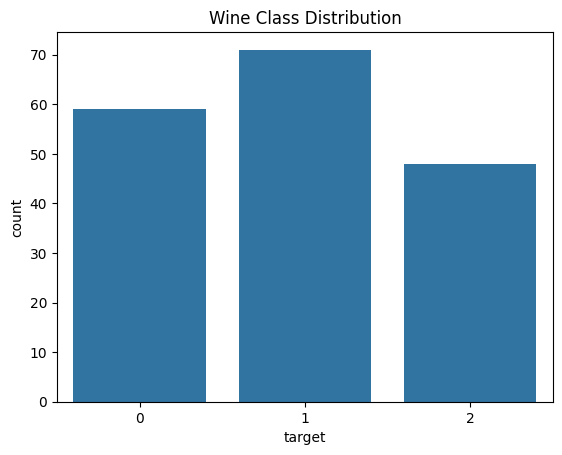

In [4]:
sns.countplot(x="target", data=df)
plt.title("Wine Class Distribution")
plt.show()

In [5]:
X = df.drop(columns=["target"])
y = df["target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Standardized shape:", X_scaled.shape)

Standardized shape: (178, 13)


In [6]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

kmeans_centroids = kmeans.cluster_centers_

In [7]:
sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
ari_kmeans = adjusted_rand_score(y, kmeans_labels)

print("K-Means Silhouette Score:", sil_kmeans)
print("K-Means Adjusted Rand Index (ARI):", ari_kmeans)


K-Means Silhouette Score: 0.2848589191898987
K-Means Adjusted Rand Index (ARI): 0.8974949815093207


In [8]:
def kmedoids_pam(X, k=3, max_iter=200, random_state=42):
    """
    PAM (Partitioning Around Medoids) implementation.
    Returns:
      labels: cluster assignment for each point
      medoid_indices: indices of chosen medoids
    """
    rng = np.random.default_rng(random_state)
    n = X.shape[0]

    # Pairwise Euclidean distances
    dist = np.sqrt(((X[:, None, :] - X[None, :, :]) ** 2).sum(axis=2))

    # Initialize medoids randomly
    medoid_indices = rng.choice(n, size=k, replace=False)

    for _ in range(max_iter):
        # Assign each point to closest medoid
        labels = np.argmin(dist[:, medoid_indices], axis=1)

        new_medoids = medoid_indices.copy()

        # Update medoids per cluster
        for c in range(k):
            members = np.where(labels == c)[0]
            if len(members) == 0:
                new_medoids[c] = rng.integers(0, n)
                continue

            # Choose member minimizing total within-cluster distance
            member_dist = dist[np.ix_(members, members)]
            costs = member_dist.sum(axis=1)
            new_medoids[c] = members[np.argmin(costs)]

        # Stop if no change
        if np.array_equal(new_medoids, medoid_indices):
            break

        medoid_indices = new_medoids

    # Final assignment
    labels = np.argmin(dist[:, medoid_indices], axis=1)
    return labels, medoid_indices


In [9]:
kmedoids_labels, medoid_idx = kmedoids_pam(X_scaled, k=3, random_state=42)
print("Medoid indices:", medoid_idx)

Medoid indices: [106  35 148]


In [10]:
sil_kmedoids = silhouette_score(X_scaled, kmedoids_labels)
ari_kmedoids = adjusted_rand_score(y, kmedoids_labels)

print("K-Medoids Silhouette Score:", sil_kmedoids)
print("K-Medoids Adjusted Rand Index (ARI):", ari_kmedoids)


K-Medoids Silhouette Score: 0.2676220575785755
K-Medoids Adjusted Rand Index (ARI): 0.7411365432162113


In [11]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

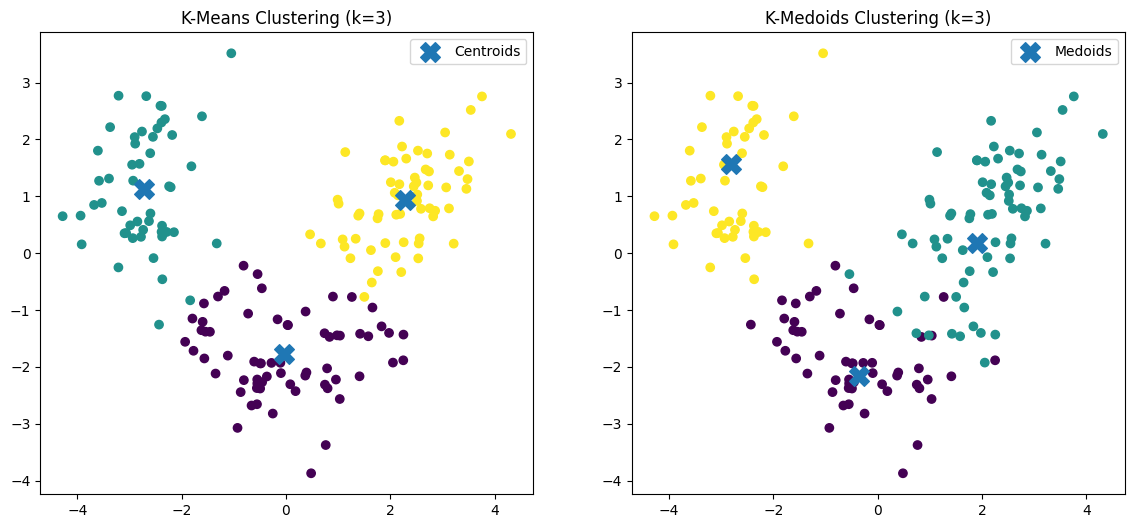

In [12]:
# Convert K-Means centroids to PCA space
kmeans_centroids_pca = pca.transform(kmeans_centroids)

# K-Medoids medoids are actual points; use their PCA coords
kmedoids_medoids_pca = X_pca[medoid_idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K-Means plot
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels)
axes[0].scatter(kmeans_centroids_pca[:, 0], kmeans_centroids_pca[:, 1],
                marker="X", s=200, label="Centroids")
axes[0].set_title("K-Means Clustering (k=3)")
axes[0].legend()

# K-Medoids plot
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmedoids_labels)
axes[1].scatter(kmedoids_medoids_pca[:, 0], kmedoids_medoids_pca[:, 1],
                marker="X", s=200, label="Medoids")
axes[1].set_title("K-Medoids Clustering (k=3)")
axes[1].legend()

plt.show()


## Results & Comparison

### Metrics
- **K-Means Silhouette:** (paste your value)
- **K-Means ARI:** (paste your value)
- **K-Medoids Silhouette:** (paste your value)
- **K-Medoids ARI:** (paste your value)

### Which produced better-defined clusters?
- The algorithm with the **higher Silhouette Score** produced more well-separated clusters.

### Observations (shapes/positioning)
- K-Means tends to form **spherical clusters** because it uses the mean (centroid).
- K-Medoids uses **actual data points** as centers (medoids), often making it **more robust to outliers**.

### When to prefer each?
- **K-Means**: faster, good for large datasets and roughly spherical clusters.
- **K-Medoids**: better when you expect **outliers**, want **robust clusters**, or prefer medoids as real points.

# MSCS 634 - Lab 3: Clustering (Wine Dataset)

## Purpose
This lab compares K-Means and K-Medoids clustering on the Wine dataset from sklearn. The data was standardized using z-score normalization, and clustering performance was evaluated using Silhouette Score and Adjusted Rand Index (ARI).

## Key Results / Insights
- K-Means and K-Medoids were run with k=3.
- Silhouette Score was used to measure cluster separation.
- ARI was used to compare clustering labels to the true wine classes.
- PCA visualization helped compare how clusters form in 2D.

## Observations
- K-Means uses centroids and tends to create spherical clusters.
- K-Medoids uses actual data points (medoids) and is more robust to outliers.
- The model with higher Silhouette and ARI performed better overall.

## Challenges / Decisions
- Python 3.14 does not easily support installing sklearn-extra (KMedoids) on Windows.
- K-Medoids was implemented using the PAM approach directly in the notebook to satisfy the algorithm requirement.